In [1]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
import numpy as np
import h5py
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should print the device index (e.g., 0)
print(torch.cuda.get_device_name(0))  # S

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
class GanglionCellDataset(Dataset):
    def __init__(self, h5_file):
        
        self.h5_file = h5_file
        with h5py.File(h5_file, 'r') as f:
            self.stimuli = np.array(f['train/stimulus'])  # (359802, 50, 50)
            self.responses = np.array(f['train/response/firing_rate_10ms'])  # (9, 359802)

        # Reshape stimuli to (N, 1, H, W) for CNN
        self.stimuli = self.stimuli[:, np.newaxis, :, :].astype(np.float32)  # (359802, 1, 50, 50)

        # Transpose responses to match sample dimension
        self.responses = self.responses.T.astype(np.float32)  # (359802, 9)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimuli = torch.tensor(self.stimuli[idx], device=DEVICE)  # Move to device
        responses = torch.tensor(self.responses[idx], device=DEVICE)  # Move to device
        return stimuli, responses

In [4]:
class GaussianNoise(nn.Module):
    def __init__(self, std: float):
        super(GaussianNoise, self).__init__()
        self.std = std

    def forward(self, x):
        if self.training:  # Only apply noise during training
            noise = torch.randn_like(x).to(x.device) * self.std  # Ensure noise is on the same device
            return x + noise
        return x

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)  # Flatten the input tensor

class Exponential(nn.Module):
    def __init__(self, train_off=False):
        super(Exponential, self).__init__()
        self.train_off = train_off

    def forward(self, x):
        if self.train_off:
            return torch.exp(x)  # Example: Exponential activation without training
        else:
            return torch.exp(x)  # Modify as needed based on the desired behavior

In [5]:
class TDRModel(nn.Module):
    """
    Base class for most models. Handles setting most of the member
    variables that are shared for most model definitions.
    """
    def __init__(self, n_units=5, noise=.05, bias=True, gc_bias=None,
                 chans=[8,8], bn_moment=.01, softplus=True,
                 inference_exp=False, img_shape=(40,50,50),
                 ksizes=(15,11,11), recurrent=False, kinetic=False,
                 convgc=False, centers=None, bnorm_d=1,
                 activ_fxn='ReLU', **kwargs):
        """
        Initializes common parameters for retinal models.
        """
        super().__init__()
        self.n_units = n_units
        self.chans = chans
        self.softplus = softplus
        self.infr_exp = inference_exp
        self.bias = bias
        self.img_shape = img_shape
        self.ksizes = ksizes
        self.gc_bias = gc_bias
        self.noise = noise
        self.bn_moment = bn_moment
        self.recurrent = recurrent
        self.kinetic = kinetic
        self.convgc = convgc
        self.centers = centers
        self.bnorm_d = bnorm_d
        assert bnorm_d in [1, 2], "Only 1D and 2D batchnorm are supported."
        self.activ_fxn = activ_fxn

    def forward(self, x):
        """
        This function should be implemented in child classes.
        """
        raise NotImplementedError("Forward function must be implemented in child class.")

    def update_shape(self, shape, kernel_size):
        """
        Helper function to update spatial dimensions after convolution.

        Parameters:
        - shape: tuple (height, width)
        - kernel_size: int or tuple

        Returns:
        - New shape after convolution
        """
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        h_out = shape[0] - kernel_size[0] + 1
        w_out = shape[1] - kernel_size[1] + 1
        return (h_out, w_out)

    def extra_repr(self):
        """
        This function is used in model printing. Shows model parameters.
        """
        s = ['n_units={}', 'noise={}', 'bias={}', 'gc_bias={}',
             'chans={}', 'bn_moment={}', 'softplus={}',
             'inference_exp={}', 'img_shape={}', 'ksizes={}']
        return ", ".join(s).format(self.n_units, self.noise, self.bias,
                                   self.gc_bias, self.chans,
                                   self.bn_moment, self.softplus,
                                   self.infr_exp, self.img_shape, self.ksizes)

    def requires_grad(self, state: bool):
        """
        Enables or disables gradient calculations.

        Parameters:
        - state (bool): True to enable gradients, False to disable.
        """
        for p in self.parameters():
            p.requires_grad = state

In [6]:
# Exact BNCNN Model
class BNCNN(TDRModel):
    """
    BatchNorm CNN for predicting ganglion cell responses.
    """

    def __init__(self, gauss_prior=0, **kwargs):
        super().__init__(**kwargs)
        self.name = 'McNiruNet'
        self.gauss_prior = gauss_prior
        modules = []
        self.shapes = []
        shape = self.img_shape[1:]

        modules.append(nn.Conv2d(self.img_shape[0], self.chans[0], kernel_size=self.ksizes[0], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[0])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[0] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[0], *shape)))
        else:
            modules.append(nn.BatchNorm2d(self.chans[0], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        modules.append(nn.Conv2d(self.chans[0], self.chans[1], kernel_size=self.ksizes[1], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[1])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[1], shape[0], shape[1])))
        else:
            modules.append(nn.BatchNorm2d(self.chans[1], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        if self.convgc:
            modules.append(nn.Conv2d(self.chans[1], self.n_units, kernel_size=self.ksizes[2], bias=self.gc_bias))
            shape = self.update_shape(shape, self.ksizes[2])
            self.shapes.append(tuple(shape))
            modules.append(GrabUnits(self.centers, self.ksizes, self.img_shape))
        else:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.Linear(size, self.n_units, bias=self.gc_bias))

        modules.append(nn.BatchNorm1d(self.n_units, eps=1e-3, momentum=self.bn_moment))

        if self.softplus:
            modules.append(nn.Softplus())
        else:
            modules.append(Exponential(train_off=True))

        self.sequential = nn.Sequential(*modules)

        if self.gauss_prior > 0:
            for i, seq_idx in enumerate([0, 6]):
                weight = self.sequential[seq_idx].weight
                filters = []
                for out_i in range(weight.shape[0]):
                    kernels = []
                    for in_i in range(weight.shape[1]):
                        prior_x = signal.gaussian(weight.shape[-1], std=self.gauss_prior)
                        prior_y = signal.gaussian(weight.shape[-2], std=self.gauss_prior)
                        prior = np.outer(prior_y, prior_x)
                        kernels.append(prior)
                    filters.append(np.asarray(kernels))
                prior = np.asarray(filters)
                denom = np.sqrt(weight.shape[0] + weight.shape[1])
                prior = prior / np.max(prior) / denom
                prior = torch.FloatTensor(prior)
                self.sequential[seq_idx].weight.data = prior

    def forward(self, x):
        if not self.training and self.infr_exp:
            return torch.exp(self.sequential(x))
        return self.sequential(x)

In [7]:
def train_model(h5_file, hyperparams, batch_size=32, lr=0.01, epochs=100, val_split=0.1):
    dataset = GanglionCellDataset(h5_file)
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    model = BNCNN(**hyperparams).to(DEVICE)
    loss_fn = nn.PoissonNLLLoss(log_input=False)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    writer = SummaryWriter(log_dir="runs/bncnn_experiment")

    loss_history, accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc, train_count = 0, 0, 0
        all_predictions, all_targets = [], []

        for stimuli, firing_rate in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)
            optimizer.zero_grad()
            predictions = model(stimuli)
            loss = loss_fn(predictions, firing_rate)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred_np, target_np = predictions.detach().cpu().numpy(), firing_rate.detach().cpu().numpy()
            
            correlations = [
                np.corrcoef(pred_np[:, i], target_np[:, i])[0, 1] if np.std(pred_np[:, i]) > 0 and np.std(target_np[:, i]) > 0 else 0
                for i in range(9)
            ]
            correlation = np.mean(correlations)
            train_acc += correlation
            train_count += 1
            all_predictions.append(pred_np)
            all_targets.append(target_np)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / train_count if train_count > 0 else 0
        loss_history.append(avg_train_loss)
        accuracy_history.append(avg_train_acc)
        writer.add_scalar("Loss/train", avg_train_loss, epoch)
        writer.add_scalar("Accuracy/train", avg_train_acc, epoch)

        model.eval()
        val_loss, val_acc, val_count = 0, 0, 0
        all_val_predictions, all_val_targets = [], []

        with torch.no_grad():
            for stimuli, firing_rate in val_loader:
                stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)
                predictions = model(stimuli)
                loss = loss_fn(predictions, firing_rate)
                val_loss += loss.item()
                
                pred_np, target_np = predictions.cpu().numpy(), firing_rate.cpu().numpy()
                correlations = [
                    np.corrcoef(pred_np[:, i], target_np[:, i])[0, 1] if np.std(pred_np[:, i]) > 0 and np.std(target_np[:, i]) > 0 else 0
                    for i in range(9)
                ]
                correlation = np.mean(correlations)
                val_acc += correlation
                val_count += 1
                all_val_predictions.append(pred_np)
                all_val_targets.append(target_np)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / val_count if val_count > 0 else 0
        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(avg_val_acc)
        writer.add_scalar("Loss/val", avg_val_loss, epoch)
        writer.add_scalar("Accuracy/val", avg_val_acc, epoch)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Train Acc: {avg_train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.6f}, Val Acc: {avg_val_acc:.4f}")

    torch.save(model.state_dict(), "bncnn_model.pth")
    print("Model saved to bncnn_model.pth")

    channels, height, width = 1, 50, 50
    # Print model summary
    summary_str = str(summary(model, input_size=(batch_size, 1, 50, 50), depth=10, verbose=2))
    # print(summary_str)

    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)
    all_val_predictions = np.vstack(all_val_predictions)
    all_val_targets = np.vstack(all_val_targets)
    
    print(f"Final Training Loss: {loss_history[-1]:.6f}")
    print(f"Final Training Accuracy: {accuracy_history[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss_history[-1]:.6f}")
    print(f"Final Validation Accuracy: {val_accuracy_history[-1]:.4f}")
    print(f"Shape of final training prediction array: {all_predictions.shape}")
    print(f"Shape of final training actual array: {all_targets.shape}")
    print(f"Shape of final validation prediction array: {all_val_predictions.shape}")
    print(f"Shape of final validation actual array: {all_val_targets.shape}")

    
    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_history, label="Train Loss")
    plt.plot(range(epochs), val_loss_history, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), accuracy_history, label="Train Accuracy")
    plt.plot(range(epochs), val_accuracy_history, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Correlation")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()
    
    return {
        'model': model,
        'loss_history': loss_history,
        'accuracy_history': accuracy_history,
        'val_loss_history': val_loss_history,
        'val_accuracy_history': val_accuracy_history,
        'all_predictions': all_predictions,
        'all_targets': all_targets,
        'all_val_predictions': all_val_predictions,
        'all_val_targets': all_val_targets
    }

Epoch 1/100: 100%|██████████| 10120/10120 [03:27<00:00, 48.70it/s]


Epoch 1/100, Train Loss: 0.018328, Train Acc: 0.0736, Val Loss: 0.038907, Val Acc: 0.0863


Epoch 2/100: 100%|██████████| 10120/10120 [02:53<00:00, 58.48it/s]


Epoch 2/100, Train Loss: -0.122623, Train Acc: 0.1150, Val Loss: -0.099341, Val Acc: 0.1246


Epoch 3/100: 100%|██████████| 10120/10120 [01:35<00:00, 105.51it/s]


Epoch 3/100, Train Loss: -0.164062, Train Acc: 0.1272, Val Loss: -0.154742, Val Acc: 0.1336


Epoch 4/100: 100%|██████████| 10120/10120 [01:54<00:00, 88.22it/s]


Epoch 4/100, Train Loss: -0.196347, Train Acc: 0.1355, Val Loss: -0.179518, Val Acc: 0.1361


Epoch 5/100: 100%|██████████| 10120/10120 [01:32<00:00, 108.92it/s]


Epoch 5/100, Train Loss: -0.222127, Train Acc: 0.1426, Val Loss: -0.191176, Val Acc: 0.1437


Epoch 6/100: 100%|██████████| 10120/10120 [01:33<00:00, 107.87it/s]


Epoch 6/100, Train Loss: -0.243551, Train Acc: 0.1476, Val Loss: -0.217269, Val Acc: 0.1459


Epoch 7/100: 100%|██████████| 10120/10120 [01:46<00:00, 94.78it/s]


Epoch 7/100, Train Loss: -0.266173, Train Acc: 0.1522, Val Loss: -0.201790, Val Acc: 0.1452


Epoch 8/100: 100%|██████████| 10120/10120 [02:09<00:00, 78.31it/s]


Epoch 8/100, Train Loss: -0.289212, Train Acc: 0.1572, Val Loss: -0.224767, Val Acc: 0.1504


Epoch 9/100: 100%|██████████| 10120/10120 [02:29<00:00, 67.92it/s]


Epoch 9/100, Train Loss: -0.308657, Train Acc: 0.1607, Val Loss: -0.228268, Val Acc: 0.1528


Epoch 10/100: 100%|██████████| 10120/10120 [01:34<00:00, 106.59it/s]


Epoch 10/100, Train Loss: -0.328946, Train Acc: 0.1653, Val Loss: -0.272826, Val Acc: 0.1584


Epoch 11/100: 100%|██████████| 10120/10120 [01:42<00:00, 98.96it/s] 


Epoch 11/100, Train Loss: -0.347838, Train Acc: 0.1687, Val Loss: -0.294412, Val Acc: 0.1594


Epoch 12/100: 100%|██████████| 10120/10120 [01:36<00:00, 104.84it/s]


Epoch 12/100, Train Loss: -0.370686, Train Acc: 0.1733, Val Loss: -0.309986, Val Acc: 0.1610


Epoch 13/100: 100%|██████████| 10120/10120 [01:35<00:00, 106.39it/s]


Epoch 13/100, Train Loss: -0.395466, Train Acc: 0.1779, Val Loss: -0.323576, Val Acc: 0.1670


Epoch 14/100: 100%|██████████| 10120/10120 [01:30<00:00, 112.42it/s]


Epoch 14/100, Train Loss: -0.412502, Train Acc: 0.1811, Val Loss: -0.310199, Val Acc: 0.1664


Epoch 15/100: 100%|██████████| 10120/10120 [01:28<00:00, 114.56it/s]


Epoch 15/100, Train Loss: -0.429112, Train Acc: 0.1840, Val Loss: -0.333133, Val Acc: 0.1706


Epoch 16/100: 100%|██████████| 10120/10120 [01:34<00:00, 106.76it/s]


Epoch 16/100, Train Loss: -0.455923, Train Acc: 0.1878, Val Loss: -0.339454, Val Acc: 0.1713


Epoch 17/100: 100%|██████████| 10120/10120 [01:59<00:00, 84.94it/s]


Epoch 17/100, Train Loss: -0.472129, Train Acc: 0.1909, Val Loss: -0.366738, Val Acc: 0.1770


Epoch 18/100: 100%|██████████| 10120/10120 [01:30<00:00, 111.72it/s]


Epoch 18/100, Train Loss: -0.484391, Train Acc: 0.1940, Val Loss: -0.368439, Val Acc: 0.1781


Epoch 19/100: 100%|██████████| 10120/10120 [01:32<00:00, 109.88it/s]


Epoch 19/100, Train Loss: -0.502327, Train Acc: 0.1961, Val Loss: -0.379026, Val Acc: 0.1802


Epoch 20/100: 100%|██████████| 10120/10120 [01:31<00:00, 110.39it/s]


Epoch 20/100, Train Loss: -0.519256, Train Acc: 0.1998, Val Loss: -0.357805, Val Acc: 0.1782


Epoch 21/100: 100%|██████████| 10120/10120 [01:29<00:00, 113.36it/s]


Epoch 21/100, Train Loss: -0.531344, Train Acc: 0.2010, Val Loss: -0.342006, Val Acc: 0.1776


Epoch 22/100: 100%|██████████| 10120/10120 [01:29<00:00, 113.41it/s]


Epoch 22/100, Train Loss: -0.549369, Train Acc: 0.2034, Val Loss: -0.419094, Val Acc: 0.1846


Epoch 23/100: 100%|██████████| 10120/10120 [01:30<00:00, 112.36it/s]


Epoch 23/100, Train Loss: -0.564943, Train Acc: 0.2060, Val Loss: -0.401264, Val Acc: 0.1848


Epoch 24/100: 100%|██████████| 10120/10120 [01:53<00:00, 89.00it/s]


Epoch 24/100, Train Loss: -0.575347, Train Acc: 0.2079, Val Loss: -0.408508, Val Acc: 0.1871


Epoch 25/100: 100%|██████████| 10120/10120 [02:23<00:00, 70.62it/s]


Epoch 25/100, Train Loss: -0.589707, Train Acc: 0.2097, Val Loss: -0.429592, Val Acc: 0.1913


Epoch 26/100: 100%|██████████| 10120/10120 [01:41<00:00, 99.99it/s] 


Epoch 26/100, Train Loss: -0.601789, Train Acc: 0.2121, Val Loss: -0.440997, Val Acc: 0.1920


Epoch 27/100: 100%|██████████| 10120/10120 [01:29<00:00, 113.56it/s]


Epoch 27/100, Train Loss: -0.610649, Train Acc: 0.2137, Val Loss: -0.462079, Val Acc: 0.1925


Epoch 28/100: 100%|██████████| 10120/10120 [01:41<00:00, 99.86it/s]


Epoch 28/100, Train Loss: -0.623347, Train Acc: 0.2147, Val Loss: -0.457799, Val Acc: 0.1931


Epoch 29/100: 100%|██████████| 10120/10120 [01:47<00:00, 94.56it/s] 


Epoch 29/100, Train Loss: -0.633017, Train Acc: 0.2169, Val Loss: -0.474429, Val Acc: 0.1938


Epoch 30/100: 100%|██████████| 10120/10120 [01:48<00:00, 93.49it/s]


Epoch 30/100, Train Loss: -0.641980, Train Acc: 0.2176, Val Loss: -0.432836, Val Acc: 0.1980


Epoch 31/100: 100%|██████████| 10120/10120 [02:08<00:00, 78.67it/s]


Epoch 31/100, Train Loss: -0.653017, Train Acc: 0.2195, Val Loss: -0.466386, Val Acc: 0.1981


Epoch 32/100: 100%|██████████| 10120/10120 [02:02<00:00, 82.94it/s]


Epoch 32/100, Train Loss: -0.665588, Train Acc: 0.2221, Val Loss: -0.491801, Val Acc: 0.1998


Epoch 33/100: 100%|██████████| 10120/10120 [02:15<00:00, 74.57it/s]


Epoch 33/100, Train Loss: -0.671310, Train Acc: 0.2224, Val Loss: -0.493394, Val Acc: 0.2030


Epoch 34/100: 100%|██████████| 10120/10120 [01:44<00:00, 97.06it/s]


Epoch 34/100, Train Loss: -0.683608, Train Acc: 0.2246, Val Loss: -0.508094, Val Acc: 0.2058


Epoch 35/100: 100%|██████████| 10120/10120 [01:44<00:00, 96.42it/s] 


Epoch 35/100, Train Loss: -0.689616, Train Acc: 0.2247, Val Loss: -0.470638, Val Acc: 0.2007


Epoch 36/100: 100%|██████████| 10120/10120 [01:46<00:00, 95.44it/s]


Epoch 36/100, Train Loss: -0.699078, Train Acc: 0.2267, Val Loss: -0.519355, Val Acc: 0.2042


Epoch 37/100: 100%|██████████| 10120/10120 [01:45<00:00, 95.68it/s]


Epoch 37/100, Train Loss: -0.708196, Train Acc: 0.2279, Val Loss: -0.492119, Val Acc: 0.2022


Epoch 38/100: 100%|██████████| 10120/10120 [01:48<00:00, 93.03it/s]


Epoch 38/100, Train Loss: -0.717037, Train Acc: 0.2292, Val Loss: -0.455128, Val Acc: 0.1996


Epoch 39/100: 100%|██████████| 10120/10120 [02:09<00:00, 78.18it/s]


Epoch 39/100, Train Loss: -0.722861, Train Acc: 0.2299, Val Loss: -0.523929, Val Acc: 0.2059


Epoch 40/100: 100%|██████████| 10120/10120 [01:57<00:00, 86.16it/s]


Epoch 40/100, Train Loss: -0.730884, Train Acc: 0.2310, Val Loss: -0.545821, Val Acc: 0.2058


Epoch 41/100: 100%|██████████| 10120/10120 [01:32<00:00, 109.93it/s]


Epoch 41/100, Train Loss: -0.738356, Train Acc: 0.2325, Val Loss: -0.528140, Val Acc: 0.2072


Epoch 42/100: 100%|██████████| 10120/10120 [01:28<00:00, 114.83it/s]


Epoch 42/100, Train Loss: -0.744683, Train Acc: 0.2324, Val Loss: -0.533001, Val Acc: 0.2058


Epoch 43/100: 100%|██████████| 10120/10120 [01:28<00:00, 114.89it/s]


Epoch 43/100, Train Loss: -0.751039, Train Acc: 0.2332, Val Loss: -0.546241, Val Acc: 0.2074


Epoch 44/100: 100%|██████████| 10120/10120 [01:38<00:00, 102.24it/s]


Epoch 44/100, Train Loss: -0.757041, Train Acc: 0.2350, Val Loss: -0.528307, Val Acc: 0.2048


Epoch 45/100: 100%|██████████| 10120/10120 [01:30<00:00, 112.26it/s]


Epoch 45/100, Train Loss: -0.760369, Train Acc: 0.2346, Val Loss: -0.525566, Val Acc: 0.2053


Epoch 46/100: 100%|██████████| 10120/10120 [01:38<00:00, 103.13it/s]


Epoch 46/100, Train Loss: -0.768524, Train Acc: 0.2366, Val Loss: -0.548032, Val Acc: 0.2104


Epoch 47/100: 100%|██████████| 10120/10120 [01:32<00:00, 109.89it/s]


Epoch 47/100, Train Loss: -0.773231, Train Acc: 0.2361, Val Loss: -0.569321, Val Acc: 0.2094


Epoch 48/100: 100%|██████████| 10120/10120 [01:36<00:00, 105.01it/s]


Epoch 48/100, Train Loss: -0.780639, Train Acc: 0.2382, Val Loss: -0.559944, Val Acc: 0.2104


Epoch 49/100: 100%|██████████| 10120/10120 [01:30<00:00, 112.10it/s]


Epoch 49/100, Train Loss: -0.787525, Train Acc: 0.2387, Val Loss: -0.548895, Val Acc: 0.2092


Epoch 50/100: 100%|██████████| 10120/10120 [01:33<00:00, 108.21it/s]


Epoch 50/100, Train Loss: -0.791293, Train Acc: 0.2394, Val Loss: -0.575573, Val Acc: 0.2136


Epoch 51/100: 100%|██████████| 10120/10120 [01:37<00:00, 103.93it/s]


Epoch 51/100, Train Loss: -0.795688, Train Acc: 0.2406, Val Loss: -0.562298, Val Acc: 0.2116


Epoch 52/100: 100%|██████████| 10120/10120 [01:28<00:00, 114.33it/s]


Epoch 52/100, Train Loss: -0.803705, Train Acc: 0.2408, Val Loss: -0.579712, Val Acc: 0.2133


Epoch 53/100: 100%|██████████| 10120/10120 [01:40<00:00, 100.63it/s]


Epoch 53/100, Train Loss: -0.805893, Train Acc: 0.2409, Val Loss: -0.532671, Val Acc: 0.2066


Epoch 54/100: 100%|██████████| 10120/10120 [01:37<00:00, 103.42it/s]


Epoch 54/100, Train Loss: -0.811688, Train Acc: 0.2425, Val Loss: -0.522795, Val Acc: 0.2130


Epoch 55/100: 100%|██████████| 10120/10120 [01:40<00:00, 100.26it/s]


Epoch 55/100, Train Loss: -0.818510, Train Acc: 0.2433, Val Loss: -0.592418, Val Acc: 0.2122


Epoch 56/100: 100%|██████████| 10120/10120 [01:35<00:00, 106.36it/s]


Epoch 56/100, Train Loss: -0.821573, Train Acc: 0.2442, Val Loss: -0.586170, Val Acc: 0.2133


Epoch 57/100: 100%|██████████| 10120/10120 [01:40<00:00, 100.73it/s]


Epoch 57/100, Train Loss: -0.824323, Train Acc: 0.2434, Val Loss: -0.560552, Val Acc: 0.2124


Epoch 58/100: 100%|██████████| 10120/10120 [01:48<00:00, 93.65it/s]


Epoch 58/100, Train Loss: -0.828282, Train Acc: 0.2449, Val Loss: -0.562684, Val Acc: 0.2105


Epoch 59/100: 100%|██████████| 10120/10120 [01:31<00:00, 110.78it/s]


Epoch 59/100, Train Loss: -0.838459, Train Acc: 0.2456, Val Loss: -0.580465, Val Acc: 0.2156


Epoch 60/100: 100%|██████████| 10120/10120 [01:36<00:00, 104.88it/s]


Epoch 60/100, Train Loss: -0.836794, Train Acc: 0.2454, Val Loss: -0.590961, Val Acc: 0.2184


Epoch 61/100: 100%|██████████| 10120/10120 [01:28<00:00, 114.23it/s]


Epoch 61/100, Train Loss: -0.842944, Train Acc: 0.2461, Val Loss: -0.607845, Val Acc: 0.2131


Epoch 62/100: 100%|██████████| 10120/10120 [01:28<00:00, 114.52it/s]


Epoch 62/100, Train Loss: -0.848015, Train Acc: 0.2469, Val Loss: -0.590485, Val Acc: 0.2156


Epoch 63/100: 100%|██████████| 10120/10120 [01:38<00:00, 102.99it/s]


Epoch 63/100, Train Loss: -0.848986, Train Acc: 0.2472, Val Loss: -0.544013, Val Acc: 0.2181


Epoch 64/100: 100%|██████████| 10120/10120 [01:42<00:00, 98.87it/s] 


Epoch 64/100, Train Loss: -0.855114, Train Acc: 0.2478, Val Loss: -0.596420, Val Acc: 0.2151


Epoch 65/100: 100%|██████████| 10120/10120 [01:28<00:00, 114.27it/s]


Epoch 65/100, Train Loss: -0.861359, Train Acc: 0.2487, Val Loss: -0.573892, Val Acc: 0.2122


Epoch 66/100: 100%|██████████| 10120/10120 [01:35<00:00, 106.26it/s]


Epoch 66/100, Train Loss: -0.861595, Train Acc: 0.2485, Val Loss: -0.593195, Val Acc: 0.2179


Epoch 67/100: 100%|██████████| 10120/10120 [01:42<00:00, 98.50it/s]


Epoch 67/100, Train Loss: -0.863076, Train Acc: 0.2482, Val Loss: -0.582287, Val Acc: 0.2203


Epoch 68/100: 100%|██████████| 10120/10120 [01:40<00:00, 101.11it/s]


Epoch 68/100, Train Loss: -0.869758, Train Acc: 0.2492, Val Loss: -0.534212, Val Acc: 0.2149


Epoch 69/100: 100%|██████████| 10120/10120 [01:37<00:00, 103.98it/s]


Epoch 69/100, Train Loss: -0.870221, Train Acc: 0.2500, Val Loss: -0.599540, Val Acc: 0.2178


Epoch 70/100: 100%|██████████| 10120/10120 [01:31<00:00, 110.40it/s]


Epoch 70/100, Train Loss: -0.876034, Train Acc: 0.2509, Val Loss: -0.591707, Val Acc: 0.2186


Epoch 71/100: 100%|██████████| 10120/10120 [01:27<00:00, 115.62it/s]


Epoch 71/100, Train Loss: -0.878996, Train Acc: 0.2512, Val Loss: -0.587572, Val Acc: 0.2173


Epoch 72/100: 100%|██████████| 10120/10120 [01:33<00:00, 108.69it/s]


Epoch 72/100, Train Loss: -0.884571, Train Acc: 0.2519, Val Loss: -0.592614, Val Acc: 0.2193


Epoch 73/100: 100%|██████████| 10120/10120 [01:30<00:00, 112.02it/s]


Epoch 73/100, Train Loss: -0.882259, Train Acc: 0.2509, Val Loss: -0.578475, Val Acc: 0.2154


Epoch 74/100: 100%|██████████| 10120/10120 [01:38<00:00, 102.95it/s]


Epoch 74/100, Train Loss: -0.885470, Train Acc: 0.2520, Val Loss: -0.592608, Val Acc: 0.2110


Epoch 75/100: 100%|██████████| 10120/10120 [01:50<00:00, 92.00it/s]


Epoch 75/100, Train Loss: -0.887905, Train Acc: 0.2524, Val Loss: -0.605494, Val Acc: 0.2215


Epoch 76/100: 100%|██████████| 10120/10120 [01:39<00:00, 101.28it/s]


Epoch 76/100, Train Loss: -0.893859, Train Acc: 0.2527, Val Loss: -0.599051, Val Acc: 0.2188


Epoch 77/100: 100%|██████████| 10120/10120 [01:34<00:00, 107.03it/s]


Epoch 77/100, Train Loss: -0.896044, Train Acc: 0.2523, Val Loss: -0.607153, Val Acc: 0.2208


Epoch 78/100: 100%|██████████| 10120/10120 [01:28<00:00, 114.45it/s]


Epoch 78/100, Train Loss: -0.902562, Train Acc: 0.2542, Val Loss: -0.655367, Val Acc: 0.2222


Epoch 79/100: 100%|██████████| 10120/10120 [01:28<00:00, 114.00it/s]


Epoch 79/100, Train Loss: -0.902104, Train Acc: 0.2543, Val Loss: -0.616304, Val Acc: 0.2218


Epoch 80/100: 100%|██████████| 10120/10120 [01:40<00:00, 100.71it/s]


Epoch 80/100, Train Loss: -0.904092, Train Acc: 0.2549, Val Loss: -0.641534, Val Acc: 0.2221


Epoch 81/100: 100%|██████████| 10120/10120 [01:29<00:00, 113.65it/s]


Epoch 81/100, Train Loss: -0.908350, Train Acc: 0.2550, Val Loss: -0.598207, Val Acc: 0.2187


Epoch 82/100: 100%|██████████| 10120/10120 [01:26<00:00, 116.94it/s]


Epoch 82/100, Train Loss: -0.907746, Train Acc: 0.2554, Val Loss: -0.597658, Val Acc: 0.2201


Epoch 83/100: 100%|██████████| 10120/10120 [01:38<00:00, 102.91it/s]


Epoch 83/100, Train Loss: -0.915652, Train Acc: 0.2549, Val Loss: -0.622000, Val Acc: 0.2206


Epoch 84/100: 100%|██████████| 10120/10120 [02:00<00:00, 84.08it/s] 


Epoch 84/100, Train Loss: -0.916741, Train Acc: 0.2554, Val Loss: -0.640799, Val Acc: 0.2236


Epoch 85/100: 100%|██████████| 10120/10120 [01:35<00:00, 105.91it/s]


Epoch 85/100, Train Loss: -0.916472, Train Acc: 0.2564, Val Loss: -0.609343, Val Acc: 0.2219


Epoch 86/100: 100%|██████████| 10120/10120 [01:27<00:00, 115.42it/s]


Epoch 86/100, Train Loss: -0.920867, Train Acc: 0.2562, Val Loss: -0.641677, Val Acc: 0.2220


Epoch 87/100: 100%|██████████| 10120/10120 [01:27<00:00, 115.12it/s]


Epoch 87/100, Train Loss: -0.919025, Train Acc: 0.2565, Val Loss: -0.492539, Val Acc: 0.2183


Epoch 88/100: 100%|██████████| 10120/10120 [01:29<00:00, 113.26it/s]


Epoch 88/100, Train Loss: -0.925112, Train Acc: 0.2560, Val Loss: -0.620151, Val Acc: 0.2244


Epoch 89/100: 100%|██████████| 10120/10120 [01:31<00:00, 110.56it/s]


Epoch 89/100, Train Loss: -0.925045, Train Acc: 0.2579, Val Loss: -0.609942, Val Acc: 0.2179


Epoch 90/100: 100%|██████████| 10120/10120 [01:42<00:00, 98.54it/s] 


Epoch 90/100, Train Loss: -0.929458, Train Acc: 0.2579, Val Loss: -0.637847, Val Acc: 0.2244


Epoch 91/100: 100%|██████████| 10120/10120 [01:41<00:00, 99.98it/s] 


Epoch 91/100, Train Loss: -0.928281, Train Acc: 0.2580, Val Loss: -0.645256, Val Acc: 0.2220


Epoch 92/100: 100%|██████████| 10120/10120 [01:51<00:00, 90.52it/s]


Epoch 92/100, Train Loss: -0.928935, Train Acc: 0.2577, Val Loss: -0.585257, Val Acc: 0.2215


Epoch 93/100: 100%|██████████| 10120/10120 [01:52<00:00, 90.30it/s]


Epoch 93/100, Train Loss: -0.933203, Train Acc: 0.2580, Val Loss: -0.538553, Val Acc: 0.2166


Epoch 94/100: 100%|██████████| 10120/10120 [01:29<00:00, 112.54it/s]


Epoch 94/100, Train Loss: -0.936904, Train Acc: 0.2583, Val Loss: -0.557859, Val Acc: 0.2255


Epoch 95/100: 100%|██████████| 10120/10120 [01:28<00:00, 114.61it/s]


Epoch 95/100, Train Loss: -0.937277, Train Acc: 0.2589, Val Loss: -0.628102, Val Acc: 0.2228


Epoch 96/100: 100%|██████████| 10120/10120 [01:26<00:00, 117.67it/s]


Epoch 96/100, Train Loss: -0.939591, Train Acc: 0.2593, Val Loss: -0.638111, Val Acc: 0.2250


Epoch 97/100: 100%|██████████| 10120/10120 [01:39<00:00, 101.30it/s]


Epoch 97/100, Train Loss: -0.939574, Train Acc: 0.2583, Val Loss: -0.615257, Val Acc: 0.2224


Epoch 98/100: 100%|██████████| 10120/10120 [01:38<00:00, 102.30it/s]


Epoch 98/100, Train Loss: -0.943596, Train Acc: 0.2601, Val Loss: -0.654089, Val Acc: 0.2257


Epoch 99/100: 100%|██████████| 10120/10120 [01:30<00:00, 111.42it/s]


Epoch 99/100, Train Loss: -0.943392, Train Acc: 0.2595, Val Loss: -0.632822, Val Acc: 0.2218


Epoch 100/100: 100%|██████████| 10120/10120 [01:37<00:00, 103.43it/s]


Epoch 100/100, Train Loss: -0.946849, Train Acc: 0.2600, Val Loss: -0.660286, Val Acc: 0.2274
Model saved to bncnn_model.pth
Layer (type:depth-idx)                   Output Shape              Param #
BNCNN                                    [32, 9]                   --
├─Sequential: 1-1                        [32, 9]                   --
│    └─0.weight                                                    ├─1,800
│    └─0.bias                                                      ├─8
│    └─1.weight                                                    ├─8
│    └─1.bias                                                      ├─8
│    └─4.weight                                                    ├─9,216
│    └─4.bias                                                      ├─8
│    └─5.weight                                                    ├─8
│    └─5.bias                                                      ├─8
│    └─9.weight                                                    ├─45,000
│    └─1

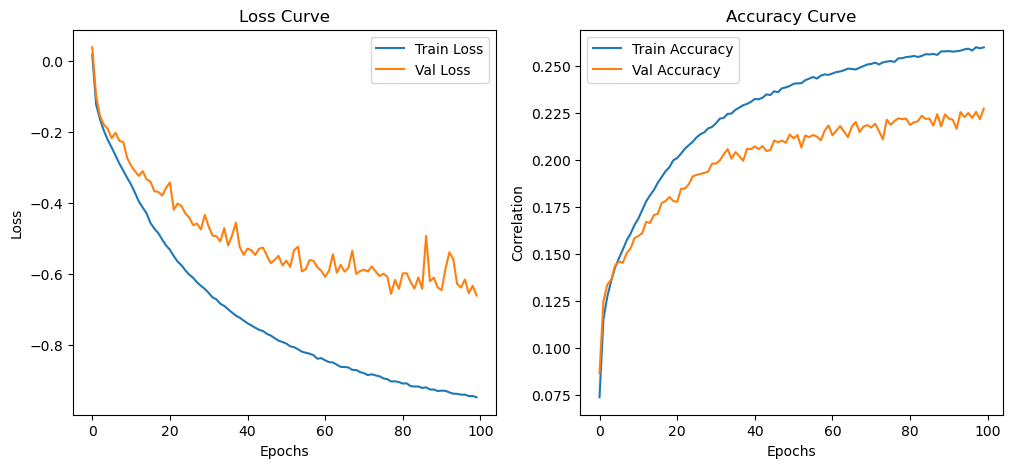

In [8]:
# Define Hyperparameters
hyperparams = {
    'img_shape': (1, 50, 50),
    'chans': [8, 8],
    'ksizes': [15, 12, 9],
    'bias': True,
    'bnorm_d': 2,
    'bn_moment': 0.01,
    'noise': 0.05,
    'activ_fxn': 'ReLU',
    'n_units': 9,
    'gc_bias': False,
    'softplus': True,
    'convgc': False,
    'centers': None
}

h5_path = r'C:\Users\krmri\Downloads\neural_code_data\neural_code_data\ganglion_cell_data\15-10-07\naturalscene.h5'
results = train_model(h5_path, hyperparams)

In [9]:
def plot_neuron_predictions(results):
    """Separate function to plot neuron predictions"""
    # Plot True vs. Predicted for 9 neurons (training data)
    print("\nPlotting training data predictions:")
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    time_steps = np.arange(results['all_targets'].shape[0])  
    
    for i, ax in enumerate(axes.flat):
        ax.plot(time_steps, results['all_targets'][:, i], label="True", linestyle="-", color="blue", alpha=0.7)
        ax.plot(time_steps, results['all_predictions'][:, i], label="Predicted", linestyle="--", color="red", alpha=0.7)
        
        ax.set_xlabel("Time (Image Index)")
        ax.set_ylabel("Firing Rate")
        ax.set_title(f"Neuron {i+1} (Training)")
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot True vs. Predicted for 9 neurons (validation data)
    print("\nPlotting validation data predictions:")
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    time_steps = np.arange(results['all_val_targets'].shape[0])  
    
    for i, ax in enumerate(axes.flat):
        ax.plot(time_steps, results['all_val_targets'][:, i], label="True", linestyle="-", color="blue", alpha=0.7)
        ax.plot(time_steps, results['all_val_predictions'][:, i], label="Predicted", linestyle="--", color="red", alpha=0.7)
        
        ax.set_xlabel("Time (Image Index)")
        ax.set_ylabel("Firing Rate")
        ax.set_title(f"Neuron {i+1} (Validation)")
        ax.legend()
    
    plt.tight_layout()
    plt.show()
# plot_neuron_predictions(results)

In [10]:
import json

def save_training_results(results, filename="training_results.json"):
    # Create a copy to avoid modifying the original
    results_to_save = results.copy()
    
    # Remove the model (can't be JSON-serialized)
    model = results_to_save.pop('model')  # Save separately with torch.save
    
    # Convert numpy arrays to lists
    for key, value in results_to_save.items():
        if isinstance(value, np.ndarray):
            results_to_save[key] = value.tolist()
    
    # Save to JSON file
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(results_to_save, f, indent=4)  # indent=4 for readability
    
    print(f"Results saved to {filename} (excluding model)")

# Example usage after training:
save_training_results(results)

Results saved to training_results.json (excluding model)


In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt

def load_training_results(filename="training_results.json"):
    """Load training results from JSON file and convert lists back to numpy arrays"""
    with open(filename, 'r', encoding='utf-8') as f:
        results = json.load(f)
    
    # Convert lists back to numpy arrays for the prediction/target data
    array_keys = ['all_predictions', 'all_targets', 'all_val_predictions', 'all_val_targets']
    for key in array_keys:
        if key in results:
            results[key] = np.array(results[key])
    
    return results


Plotting training data predictions:


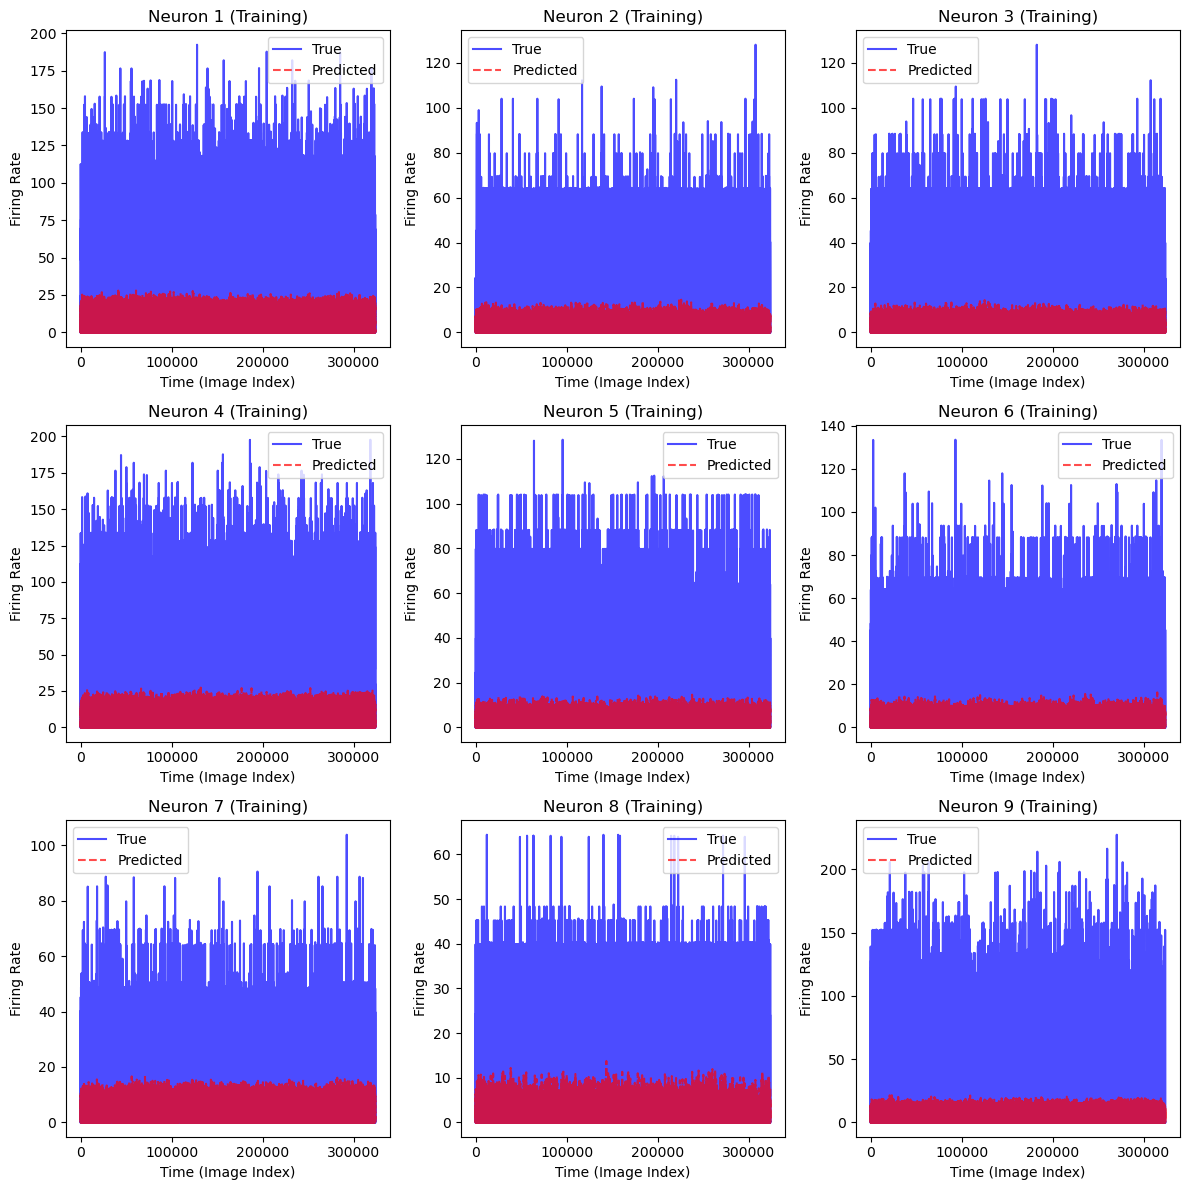


Plotting validation data predictions:


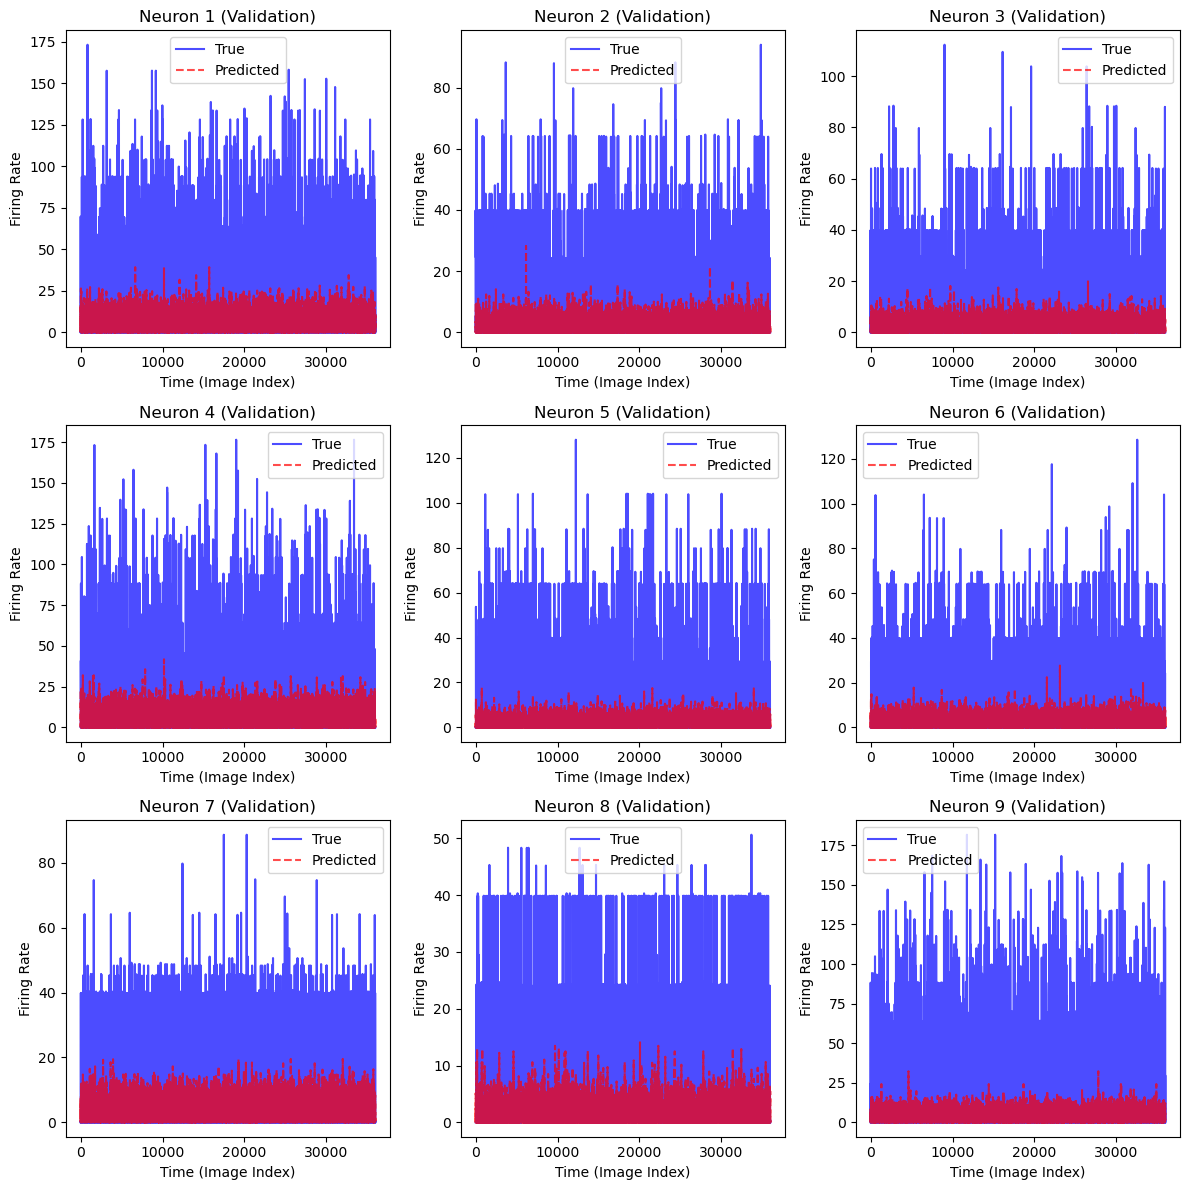

In [12]:
# Load the saved results
loaded_results = load_training_results("training_results.json")

# Pass to your plotting function
plot_neuron_predictions(loaded_results)